In [1]:
import pandas as pd
import numpy as np
import os
import math

In [2]:
class DI:

    def open_file(self , path):
        file_lst = os.listdir(path)
        data = []
        for file in file_lst:
            with open(os.path.join(path , file), 'r', encoding='utf-8') as f:
                data.extend(f.readlines()[2:])
        return data
 
    def get_data(self , txt):
        p_lst = []                        #p_lst是存储全部文献内容的列表（每篇文献为列表中的一个值）
        t_p_lst = []                      #t_p_lst是为了提取出p_lst的临时列表
        for t in txt:
            t_p_lst.append(t[:-1])
            if t =='\n':
                p_lst.append(t_p_lst)
                t_p_lst = []
        return p_lst
    
    def get_reference(self , p):             #此函数可以提取出该文献内容中参考文献的列表
        reference_lst = []
        on0 = False
        on1 = True
        for pi in p:
            if pi[:2] == 'CR':
                on0 = True
            if pi[:2] == 'NR':
                on1 = False
            if on0 == True and on1 == True:
                reference_lst.append(pi[3:])
        return reference_lst
    
    def get_ti(self , p):             #此函数可以提取出该文献内容中参考文献的列表
        for pi in p:
            if pi[:2] == 'TI':
                p_ti = pi[2:]
        return p_ti
    
    def get_tc(self , p):             #此函数可以提取出该文献内容中参考文献的列表
        for pi in p:
            if pi[:2] == 'TC':
                p_ti = int(pi[2:])
        return p_ti
    
    def get_NB_NF(self , citing , R_FP):
        NB = 0
        NF = 0
        for p in citing:
            on = False
            p_r_lst = self.get_reference(p)             #单篇施引文献的参考文献列表
            for p_r in p_r_lst:
                if p_r in R_FP:
                    on = True
            if on == True:                        #当引用FP的参考文献大于1次时，算入NB
                NB += 1
            else:
                NF += 1
        return NB , NF
    
    def get_NBn(self , citing , R_FP , n):
        NB = 0
        for p in citing:
            on = 0
            p_r_lst = self.get_reference(p)             #单篇施引文献的参考文献列表
            for p_r in p_r_lst:
                if p_r in R_FP:
                    on += 1
            if on >= n:                        #当引用FP的参考文献大于n次时，算入NB
                NB += 1
        return NB
    
    def get_NRn(self , cited , R_FP , DOI , n):
        NR = 0
        for p in cited:
            on0 = False
            on1 = 0
            p_r_lst = self.get_reference(p)             #单篇FP参考文献的施引文献的全参考文献列表
            for p_r in p_r_lst:
                if DOI in p_r:
                    on0 = True

                if p_r in R_FP:
                    on1 += 1
            if on0 == False and on1 >= n:           #当没有引用FP，但引用了FP参考文献至少2次的论文数量，算入NR
                NR += 1
        return NR

    def get_DI(self , NB , NF , NR):
        DI = (NF - NB)/(NF + NB + NR)
        return DI

    def get_DI_star(self , NB , NF , NR):
        DI = (NF)/(NF + NB + NR)
        return DI

    def get_DI_sharp(self , NB , NF , NR):
        DI = (NB)/(NF + NB + NR)
        return DI

In [3]:
def get_result(DI , path , percentage):
    
    di = DI()
    
    citing_path = os.path.join(path , 'citing')
    citing_data = di.open_file(citing_path)

    FP_path = os.path.join(path , 'FP')
    FP_data = di.open_file(FP_path)

    cited_path = os.path.join(path , 'cited')
    cited_data = di.open_file(cited_path)

    with open(os.path.join(path , 'DOI.txt'), 'r', encoding='utf-8') as f:
        doi = f.read()
    FP_DOI = 'DOI '+ doi
    
    FP = di.get_data(FP_data)[0]
    citing = di.get_data(citing_data)
    cited = di.get_data(cited_data)
    R_FP = di.get_reference(FP)
    ti = di.get_ti(FP)
    tc = di.get_tc(FP)
    
    len_R = len(R_FP)
#     print(r'参考文献总数量 =',len_R)
    
    vaild_cited = len(citing)
#     print(r'NB+NF (FP总被引量) =',vaild_cited)
    
    total_cited_R = len(cited)
#     print(r'FP所有参考文献的总被引量 =',total_cited_R)
    
    NB,NF = di.get_NB_NF(citing , R_FP)
#     print(r'NB =',NB)
#     print(r'NF =',NF)
    
    NR1 = di.get_NRn(cited , R_FP , FP_DOI , 1)
#     print(r'NR1 =',NR1)
    
    NB5 = di.get_NBn(citing , R_FP , 5)
#     print(r'NB5 =',NB5)
    
    DI5 = di.get_DI(NB5 , NF , NR1)
#     print(r'DI5 =', DI5)
    
    threshold = math.ceil(len_R * (percentage/100))
#    print(r'threshold =', threshold)
    
    NRp10 = di.get_NRn(cited , R_FP , FP_DOI , threshold)
#    print(r'NRp10 =',NRp10)
    
    NBp10 = di.get_NBn(citing , R_FP , threshold)
#    print(r'NBp10 =',NBp10)
    
    DI = di.get_DI(NB , NF , NR1)
#    print(r'DI =', DI)
    
    DI_star = di.get_DI_star(NB , NF , NR1)
#    print(r'DI* =', DI_star)
    
    DI_sharp = di.get_DI_sharp(NB , NF , NR1)
#    print(r'DI# =', DI_sharp)
    
    DIp10 = di.get_DI(NBp10 , NF , NRp10)
#    print(r'DIp10 =', DIp10)
    
    out_lst = [ti , tc , vaild_cited , len_R , total_cited_R , NB , NF , NR1 ,  DI , DI5 , DIp10 , NRp10 , NBp10 , threshold  , NB5 , DI_star , DI_sharp ]
    
    return out_lst

In [4]:
# [len_R , vaild_cited , total_cited_R , NB , NF , NR1 ,  DI , DI5 , DIp10 , NRp10 , NBp10 , threshold  , NB5 , DI_star , DI_sharp]
#column = ['论文题目' , '参考文献数量','被引','参考文献总被引','NB','NF','NR','DI','DI5','DIp10','NRp10','NBp10','threshold','NB5','DI*','DI#']
column = ['论文题目','被引量','有效被引量' , '参考文献数量','参考文献总被引','NB','NF','NR','DI','DI5','DIp10','NRp10','NBp10','threshold','NB5','DI*','DI#']

In [10]:
path_o = r'C:\Users\11047\Music\SCIENTOMETIRCS'

percentage = 10

t_lst = []
path_lst = os.listdir(path_o)
for pathi in path_lst:
    path = os.path.join(path_o , pathi)
    print(path)
    t_lst.append(get_result(DI , path , percentage))
    
lst_array = np.array(t_lst)
Dframe = pd.DataFrame(lst_array)

C:\Users\11047\Music\SCIENTOMETIRCS\1
C:\Users\11047\Music\SCIENTOMETIRCS\10
C:\Users\11047\Music\SCIENTOMETIRCS\100
C:\Users\11047\Music\SCIENTOMETIRCS\101
C:\Users\11047\Music\SCIENTOMETIRCS\102
C:\Users\11047\Music\SCIENTOMETIRCS\103
C:\Users\11047\Music\SCIENTOMETIRCS\104
C:\Users\11047\Music\SCIENTOMETIRCS\105
C:\Users\11047\Music\SCIENTOMETIRCS\106
C:\Users\11047\Music\SCIENTOMETIRCS\11
C:\Users\11047\Music\SCIENTOMETIRCS\12
C:\Users\11047\Music\SCIENTOMETIRCS\13
C:\Users\11047\Music\SCIENTOMETIRCS\14
C:\Users\11047\Music\SCIENTOMETIRCS\15
C:\Users\11047\Music\SCIENTOMETIRCS\16
C:\Users\11047\Music\SCIENTOMETIRCS\17
C:\Users\11047\Music\SCIENTOMETIRCS\18
C:\Users\11047\Music\SCIENTOMETIRCS\19
C:\Users\11047\Music\SCIENTOMETIRCS\2
C:\Users\11047\Music\SCIENTOMETIRCS\20
C:\Users\11047\Music\SCIENTOMETIRCS\21
C:\Users\11047\Music\SCIENTOMETIRCS\22
C:\Users\11047\Music\SCIENTOMETIRCS\23
C:\Users\11047\Music\SCIENTOMETIRCS\24
C:\Users\11047\Music\SCIENTOMETIRCS\25
C:\Users\11047\Music

In [12]:
Dframe.columns = column
Dframe['被引量'] = Dframe['被引量'].astype('int')
Dframe.sort_values(by = '被引量' , ascending=False)

,论文题目,被引量,有效被引量,参考文献数量,参考文献总被引,NB,NF,NR,DI,DI5,DIp10,NRp10,NBp10,threshold,NB5,DI*,DI#
0,"Software survey: VOSviewer, a computer progra...",2813,2609,37,9622,597,2012,9094,0.12090916858925062,0.1780871127076785,0.797242497972425,408,46,4,29,0.17192172947107578,0.051012560881825174
18,Theory and practise of the g-index,1103,944,13,5364,837,107,4263,-0.14019589014787787,0.020282588878760256,-0.07769145394006659,617,177,2,18,0.020549260610716342,0.1607451507585942
28,The journal coverage of Web of Science and Sc...,798,748,26,2858,164,584,2588,0.12589928057553956,0.18150361748977667,0.5673758865248227,379,24,3,7,0.1750599520383693,0.049160671462829736
39,CO-WORD ANALYSIS AS A TOOL FOR DESCRIBING THE...,569,498,20,6188,80,418,6095,0.05126649476717731,0.06417933364041148,0.27456258411843876,1058,10,2,0,0.06340057636887608,0.012134081601698772
50,Negative results are disappearing from most d...,523,495,59,14578,305,190,13826,-0.008030165491236646,0.01103124332787702,0.4644808743169399,156,20,6,35,0.013267229942043154,0.021297395433279798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,A review of emerging trends in global PPP res...,135,129,88,38438,79,50,38139,-0.0007578133166091773,0.0008375428586384694,0.07179487179487179,527,8,9,18,0.0013065746838089266,0.002064388000418104
6,"Nanotechnology - Interdisciplinarity, pattern...",134,102,15,781,59,43,698,-0.02,0.058029689608636977,0.2457627118644068,61,14,2,0,0.05375,0.07375
8,Visualizing the intellectual structure and ev...,131,128,124,24216,107,21,24059,-0.0035556290569314095,0.0,0.05442176870748299,268,5,13,21,0.0008682350022739488,0.004423864059205358
2,Inter-country R&D efficiency analysis: An app...,126,100,50,25078,74,26,24897,-0.0019202304276513182,0.0002405484504670649,0.029556650246305417,157,20,5,20,0.0010401248149777974,0.0029603552426291156


In [26]:
df = Dframe.sort_values(by = '被引量' , ascending=False)

In [41]:
def ref_classify(x):
    if x <= 20:
        return  1       # '1-20'
    elif x <= 40:
        return  2     #'21-40'
    elif x <= 60:
        return  3      # '41-60'
    else:
        return  4       #'61以上'
df['参考文献分类'] = df['参考文献数量'].apply(ref_classify)

In [37]:
df['参考文献数量']

0       37
1       13
2       26
3       20
4       59
      ... 
97      88
98      15
99     124
100     50
101      6
Name: 参考文献数量, Length: 102, dtype: int64

# 可视化

In [20]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 34987 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24341 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 37327 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 34987 missing from current font.
  font.set_text(s, 0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 24341 missing from current font.
  font.set_text(s, 0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 37327 missing from current font.
  font.set_text(s, 0,

<Figure size 1440x1152 with 0 Axes>

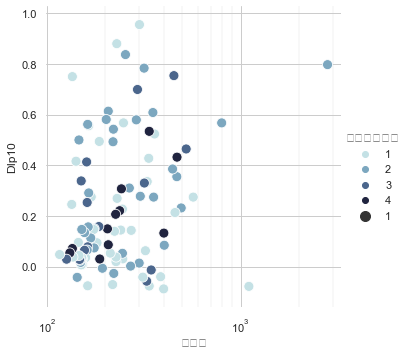

In [44]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20,16))
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=df,
    x="被引量", y="DIp10",
    hue="参考文献分类", size=1,
    palette=cmap, sizes=(100, 100),
)

g.set(xscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)


g.despine(left=True, bottom=True)
plt.savefig('DIp10.png')

E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21442 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 32771 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25991 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 29486 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20998 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 31867 missing from current font.
  font.set_text(s

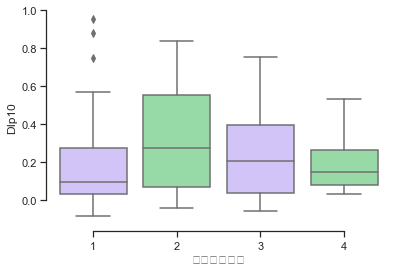

In [56]:
sns.set_theme(style="ticks", palette="pastel")

sns.boxplot(x="参考文献分类", y="DIp10",
            #hue="参考文献分类", 
            palette=["m", "g"],
            data=df)
sns.despine(offset=5, trim=True)
plt.savefig('DIp10_box.png')

E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 34987 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24341 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 37327 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 34987 missing from current font.
  font.set_text(s, 0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 24341 missing from current font.
  font.set_text(s, 0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 37327 missing from current font.
  font.set_text(s, 0,

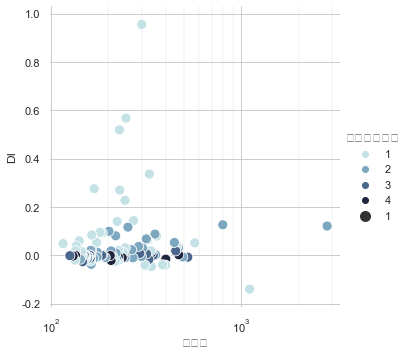

In [46]:
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=df,
    x="被引量", y="DI",
    hue="参考文献分类", size=1,
    palette=cmap, sizes=(100, 100),
)

g.set(xscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)


g.despine(left=True, bottom=True)

plt.savefig('DI.png')

E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21442 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 32771 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25991 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 29486 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20998 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 31867 missing from current font.
  font.set_text(s

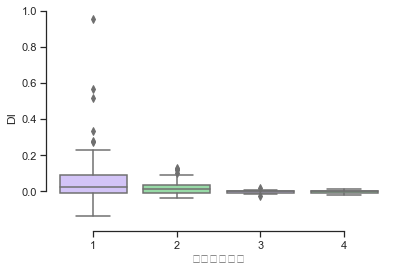

In [54]:
sns.set_theme(style="ticks", palette="pastel")

sns.boxplot(x="参考文献分类", y="DI",
            #hue="参考文献分类", 
            palette=["m", "g"],
            data=df)
sns.despine(offset=5, trim=True)
plt.savefig('DI_box.png')

E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 34987 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24341 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 37327 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 34987 missing from current font.
  font.set_text(s, 0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 24341 missing from current font.
  font.set_text(s, 0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 37327 missing from current font.
  font.set_text(s, 0,

<Figure size 1440x1152 with 0 Axes>

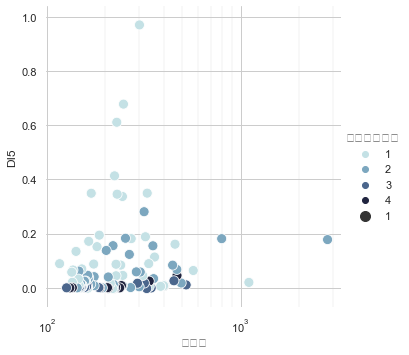

In [48]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20,16))
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=df,
    x="被引量", y="DI5",
    hue="参考文献分类", size=1,
    palette=cmap, sizes=(100, 100),
)

g.set(xscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)


g.despine(left=True, bottom=True)
plt.savefig('DI5.png')

E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21442 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 32771 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 25991 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 29486 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20998 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\SOFTWARE\ipython\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 31867 missing from current font.
  font.set_text(s

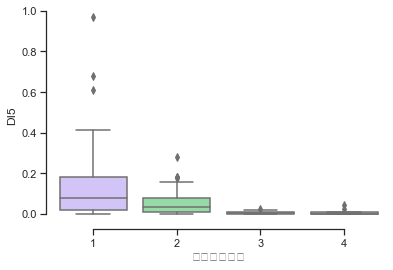

In [55]:
sns.set_theme(style="ticks", palette="pastel")

sns.boxplot(x="参考文献分类", y="DI5",
            #hue="参考文献分类", 
            palette=["m", "g"],
            data=df)
sns.despine(offset=5, trim=True)
plt.savefig('DI5_box.png')